# ATM S 582 Project: Pseudospectral Method with Leapfrog Time Differencing

### Import packages

In [1]:
%pylab inline
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Define constants

In [2]:
G = 9.81
H = 400.
BETA = 2.29e-11
C = np.sqrt(G*H)
TS = (2*BETA*C)**(-1/2)
LS = (C/(2*BETA))**(1/2)
A1 = (LS**2)/(TS**3)
A2 = LS/(TS**3)
EPS = 0.1*1/TS

### Define parameters

In [4]:
cfl = 0.2    # Courant number
lx = 1.25e7  # length scale for x domain in m
lxh = lx/3   # length scale for heating in m
ly = 5e6     # length of half y domain in m
dx = 2e5     # x grid spacing in m
dy = 2e5     # y grid spacing in m
lt = 5e6     # time length in s

dt = int(cfl*dx/C)               # time step in s
tspan = np.arange(0,lt+dt,dt)    # array of times
xgrid = np.arange(-lx+(lx/5),lx+(lx/5),dx)  # x grid points 
ygrid = np.arange(-ly,ly,dy)  # y grid points

nt = len(tspan)  # number of time steps
nx = len(xgrid)  # number of x grid points
ny = len(ygrid)  # number of y grid points

kx = 2*np.pi*fftfreq(nx,dx) # zonal wavenumbers
ky = 2*np.pi*fftfreq(ny,dy) # meridional wavenumbers

### Compute solutions

In [5]:
### Initialize arrays
u = np.zeros((nt,ny,nx))
v = np.zeros((nt,ny,nx))
phi = np.zeros((nt,ny,nx))
q1 = np.zeros((ny,nx))
q2 = np.zeros((ny,nx))

### Compute heating
for ix in range(nx):
    if np.abs(xgrid[ix]) <= lxh:
        f1 = A1*np.cos((np.pi*xgrid[ix])/(2*lxh))
        f2 = A2*np.cos((np.pi*xgrid[ix])/(2*lxh))
    else:
        f1 = 0
        f2 = 0
    for iy in range(ny):
        q1[iy,ix] = f1*np.exp(-(ygrid[iy]**2)/(4*LS**2))
        q2[iy,ix] = f2*ygrid[iy]*np.exp(-(ygrid[iy]**2)/(4*LS**2))   

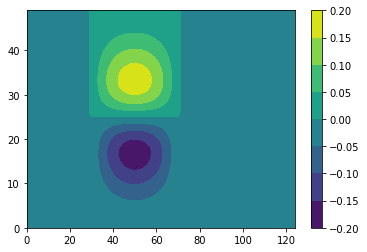

In [6]:
plt.contourf(q2);plt.colorbar()

In [7]:
### Choose type of heating: q1 = symmetric, q2 = antisymmetric
q = q1

### Initialize leapfrog method with one step forward

### Transform to wavenumber space
ux_fft = fft(u[0,:,:],axis=1)
vy_fft = fft(v[0,:,:],axis=0)
phix_fft = fft(phi[0,:,:],axis=1)
phiy_fft = fft(phi[0,:,:],axis=0)

### Compute derivatives
dudx_fft = 1j*kx[None,:]*ux_fft
dvdy_fft = 1j*ky[:,None]*vy_fft
dphidx_fft = 1j*kx[None,:]*phix_fft
dphidy_fft = 1j*ky[:,None]*phiy_fft
    
### Transform back to physical space
dudx = np.real(ifft(dudx_fft,axis=1))
dvdy = np.real(ifft(dvdy_fft,axis=0))
dphidx = np.real(ifft(dphidx_fft,axis=1))
dphidy = np.real(ifft(dphidy_fft,axis=0))

### Step forward one time step
u[1,:,:] = u[0,:,:] - dt*(-BETA*ygrid[:,None]*v[0,:,:] + dphidx[:,:] + EPS*u[0,:,:])
v[1,:,:] = v[0,:,:] - dt*(BETA*ygrid[:,None]*u[0,:,:] + dphidy[:,:] + EPS*u[0,:,:])
phi[1,:,:] = phi[0,:,:] - dt*(G*H*(dudx[:,:] + dvdy[:,:]) + EPS*phi[0,:,:] + q[:,:])

### Meridional boundary condition
v[1,0,:] = 0.
        
### Step forward using leapfrong time-differencing
for it in range(2,nt):
    ### Transform to spectral space
    ux_fft = fft(u[it-1,:,:],axis=1)
    vy_fft = fft(v[it-1,:,:],axis=0)
    phix_fft = fft(phi[it-1,:,:],axis=1)
    phiy_fft = fft(phi[it-1,:,:],axis=0)

    ### Compute derivatives
    dudx_fft = 1j*kx[None,:]*ux_fft
    dvdy_fft = 1j*ky[:,None]*vy_fft
    dphidx_fft = 1j*kx[None,:]*phix_fft
    dphidy_fft = 1j*ky[:,None]*phiy_fft

    ### Transform back to physical space
    dudx = np.real(ifft(dudx_fft,axis=1))
    dvdy = np.real(ifft(dvdy_fft,axis=0))
    dphidx = np.real(ifft(dphidx_fft,axis=1))
    dphidy = np.real(ifft(dphidy_fft,axis=0))

    ### Step forward with leapfrog scheme
    u[it,:,:] = (1/(1+EPS*2*dt))*(u[it-2,:,:] - 2*dt*(-BETA*ygrid[:,None]*v[it-1,:,:] + dphidx[:,:]))
    v[it,:,:] = (1/(1+EPS*2*dt))*(v[it-2,:,:] - 2*dt*(BETA*ygrid[:,None]*u[it-1,:,:] + dphidy[:,:]))
    phi[it,:,:] = (1/(1+EPS*2*dt))*(phi[it-2,:,:] - 2*dt*(G*H*(dudx[:,:] + dvdy[:,:]) + q[:,:]))
    
    ### Meridional boundary condition
    v[it,0,:] = 0.

### Plot solutions

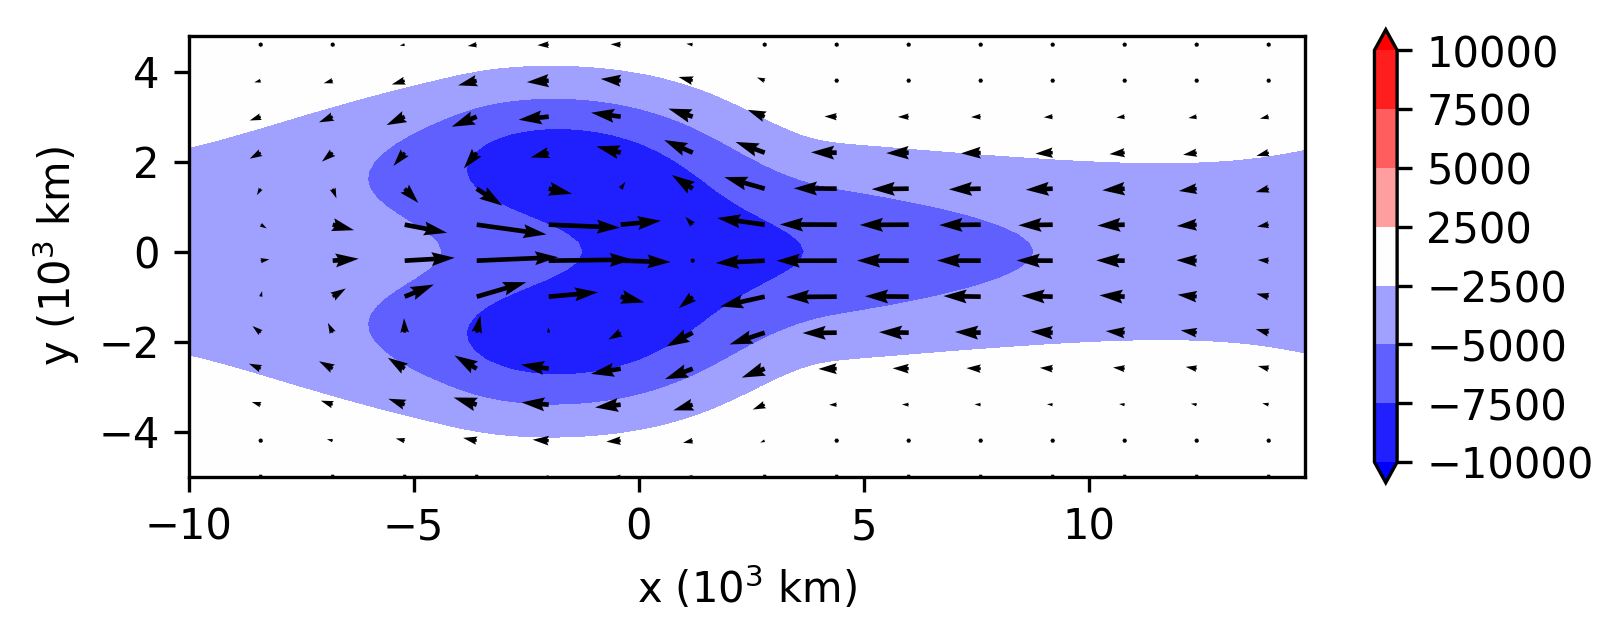

In [8]:
fig, ax = plt.subplots(figsize=(6,2),dpi=300)
plt.contourf(xgrid/1e6,ygrid/1e6,phi[-1,:,:],
             levels=np.delete(np.arange(-10000,12500,2500),4),cmap=get_cmap('bwr'), extend='both')
plt.colorbar()
plt.quiver(xgrid[::8]/1e6,ygrid[::4]/1e6,u[-1,::4,::8],v[-1,::4,::8],color='k',scale=2000)
plt.xlabel('x ($10^3$ km)')
plt.ylabel('y ($10^3$ km)')
ax.set_aspect('equal')
plt.show()